# Aprendiendo Fashion-MNIST con PyTorch

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [1]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

In [2]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [3]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [4]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme (i.e. normalize los valores de los pixeles) los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Explore algunos ejemplos de estos conjuntos. Que formato poseen?

**3)** Visitando la página web de FashionMNIST, cree un diccionario de Python `Dict()` asociando cada categoría a un nombre adecuado de la misma.

**4)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [6]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([
                                transforms.ToTensor()
                                ,transforms.Normalize((0.5,), (0.5,))
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
train_set = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

In [7]:
# 2.2)
len(train_set),len(valid_set)

(60000, 10000)

In [8]:
i = np.random.randint(len(train_set))
print(f"i={i}")
image,label = train_set[i]
label
image.shape

i=47394


torch.Size([1, 28, 28])

In [9]:
image.numpy().squeeze().shape

(28, 28)

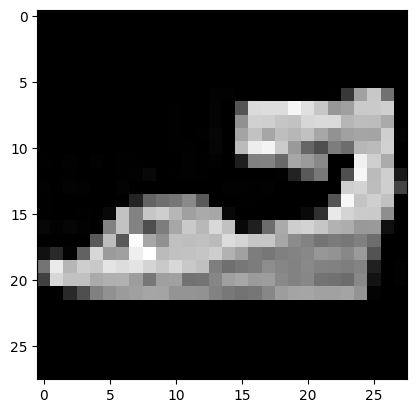

In [10]:
plt.imshow(image.numpy().squeeze(),cmap='Greys_r')

In [11]:
# 2.3)
label_names = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

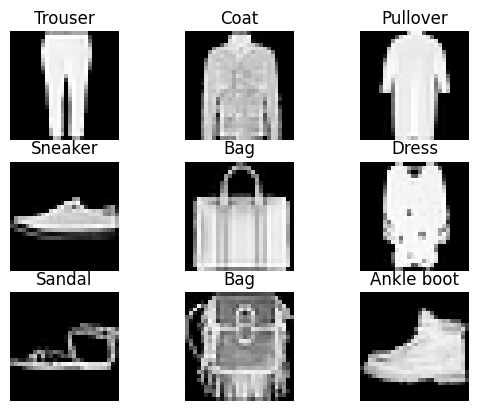

In [12]:
# 2.4)
figure = plt.figure()
cols, rows = 3,3
for i in range(1, cols*rows+1):
  j = torch.randint(len(train_set), size=(1,)).item()
  image, label = train_set[j]
  figure.add_subplot(rows, cols, i)
  plt.title(label_names[label])
  plt.axis("off")
  plt.imshow(image.numpy().squeeze(), cmap="Greys_r")
plt.show()

## Ejercicio 3)

Creando un `DataLoader` para alimentar el modelo con batchs (lotes) de entrenamiento.

**1)** Cree los `DataLoader`s para cada conjunto. Defínalos con un `batch_size` de 100 y con el flag `shuffle` seteado a `True`.

**2)** Use uno de los `DataLoader`s creados anteriormente para explorar algunos elementos del conjunto.

Notar que, el iterador devuelve el batch en un par `(image,label)`.

El objeto `images` es un tensor de dimensiones `(100,1,28,28)`.
El 100 es el tamaño del batch.
El 1 porque hay un solo canal (en este caso, un canal de escala de grises, pero podría haber varios, p. ej. uno por cada color de {Red, Green Blue} en caso que fuesen imagenes a color).
Luego, 28 y 28 porque cada imagen del dataset es de 28 x 28 píxeles.

El objeto `labels` es un tensor de dimensiones `(100,)`.
La $i$-ésima entrada `labels[i]` de `labels` es un número en $\{0,1,...,9\}$ indicando la categoría a la que pertenece la $i$-ésima imagen en el batch, guardada en `images[i]`.

In [13]:
# 3.1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = 100, shuffle = True)

In [14]:
# Cargar únicamente los pesos del Autoencoder preentrenado
import torch
from torch import nn
# Debes tener la misma definición de Autoencoder que se usó al entrenar
from autoencoder import Autoencoder  # o copia la clase Autoencoder a tu notebook

checkpoint_path = "/home/usuario/Documentos/RedesNeuronales/TPFinal/Clasificadora/1_design/autoencoder_fashionmnist.pt"
checkpoint = torch.load(checkpoint_path, map_location="cpu")

# Fijamos manualmente el hiperparámetro de dropout (por ejemplo 0.15)
dropout_autoencoder = 0.15
autoencoder = Autoencoder(dropout=dropout_autoencoder)
autoencoder.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

## Ejercicio 4)

Defina una red neuronal de 4 capas, una de entrada, dos ocultas de $n_1=128$ y $n_2=64$ neuronas, respectivamente, y una de salida de 10 neuronas.

En las capas intermedias utilice neuronas tipo ReLU y agregueles un *dropout* de p=0.2.
En la capa de salida no utilice funciones de activación ni dropout.

Las capas sucesivas tienen que estar totalmente conectadas entre si.

In [15]:
class Clasificadora(nn.Module):
    def __init__(self, p, n1, n2, encoder=None):
        super().__init__()
        self._dropout = p
        self.encoder = encoder

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*7*7, out_features=n1),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(in_features=n1, out_features=n2),
            nn.ReLU(),
            nn.Dropout(p),
            nn.Linear(in_features=n2, out_features=10)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

## Ejercicio 5)

Entrenamos el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` a partir del `train_set` (conjunto de entranmiento) y del `valid_set` (conjunto de validación) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando la **Cross Entropy Loss**.

**IMPORTANTE:** Notar que la **Cross Entropy Loss** aplica automáticamente una `log_softmax`.

**5)** Cree un optimizador que utilice el método de **Stochastic Gradient Descent** con un learning rate igual a $10^{-3}$.

**6)** Cree una instancia del modelo.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop de entrenamiento y validación que trabaje con el `train_loader` y el `valid_loader`, respectivamente, usando un numero arbitrario de épocas.
Este loop debe guardar en cuatro listas los valores de los promedios del **Cross Entropy Loss** y las fracciones de clasificaciones correctas o **precisión** (accuracy) sobre el conjunto de **entrenamiento** y el de **validación**, respectivamente.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso anterior para graficar en función de las épocas la **Cross Entropy Loss** de **entrenamiento** y de **validación**.
Realize un gráfico análogo pero con la **precisión**.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Repita los experimentos variando hiperparámetros. Por ejemplo:

- El learning-rate.
- El optimizador (ej. puede usar ADAM).
- El valor de dropout.
- El número de neuronas en las capas intermedias.
- El número de épocas de entrenamiento.
- El tamaño de los lotes.

Discuta los resultados.

In [16]:
# 5.1)
# Definimos la función de entrenamiento
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    num_samples = len(dataloader.dataset)
    nun_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        batch_size = len(X)
        sum_samples += batch_size
        pred = model(X)
        loss = loss_fn(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()*batch_size
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        if batch % (nun_batches/10) == 0:
            avrg_loss = sum_loss/sum_samples
            precision = sum_correct/sum_samples
            print(f"@train_loop batch={batch:>5d} avrg_loss={avrg_loss:>7f} processed samples={100*sum_samples/num_samples:>5.1f}%")
    assert num_samples == sum_samples
    avrg_loss = sum_loss/sum_samples
    precision = sum_correct/sum_samples
    return avrg_loss, precision

In [17]:
# 5.2)
# Definimos la función de validación
def eval_loop(dataloader, model, loss_fn):
    model.eval()
    num_samples = len(dataloader.dataset)
    nun_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0

    with torch.no_grad():
        for X,y in dataloader:
          X = X.to(device)
          y = y.to(device)
          batch_size = len(X)
          sum_samples += batch_size
          pred = model(X)
          loss = loss_fn(pred,y)
          sum_loss += loss.item()*batch_size
          sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    assert num_samples == sum_samples
    avrg_loss = sum_loss/sum_samples
    precision = sum_correct/sum_samples
    print(f"@eval_loop avg_loss={avrg_loss:>8f} precision={100*precision:>0.1f}%")
    return avrg_loss, precision

In [18]:
# 5.3)
batch_size = 100
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

num_train_batches = len(train_loader)
num_valid_batches = len(valid_loader)
print(f'num_train_batches={num_train_batches}')
print(f'num_valid_batches={num_valid_batches}')

num_train_batches=600
num_valid_batches=100


In [19]:
# 5.4)
loss_fn = nn.CrossEntropyLoss()

In [20]:
# 5.5)
# Ejemplo: pasar encoder a tu modelo Clasificadora con dropout fijo en la clasificadora
# p_dropout_clf = 0.2
# clasificador = Clasificadora(p=p_dropout_clf, n1=128, n2=64, encoder=autoencoder.encoder)

In [21]:
# 5.6)
#learning_rate = 1e-3
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(clasificador.classifier.parameters(), lr=learning_rate, eps=1e-08, weight_decay= 0, amsgrad= False)

In [22]:
# 5.7)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#clasificador = clasificador.to(device)

In [23]:
import torch
import torch.nn as nn
import json
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# ---------------------------------------------------------
#   PARÁMETROS FIJOS DEL CLASIFICADOR
# ---------------------------------------------------------
n1 = 128
n2 = 64
p_dropout_clf = 0.2
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss()

# Learning rates a testear
experimentos = {
    "Exp 1": {"learning_rate": 1e-3},
    "Exp 2": {"learning_rate": 5e-4},
    "Exp 3": {"learning_rate": 1e-4}
}

# Carpeta para guardar resultados
os.makedirs("experimentos_resultados", exist_ok=True)

# Diccionario donde se guarda TODO
resultados_globales = {}

# ---------------------------------------------------------
#   LOOP DE EXPERIMENTOS
# ---------------------------------------------------------
for nombre_exp, params in experimentos.items():
    print(f"\n============================")
    print(f"      EJECUTANDO {nombre_exp}")
    print(f"============================")

    lr = params["learning_rate"]

    # Crear clasificador
    clasificador = Clasificadora(
        p=p_dropout_clf,
        n1=n1,
        n2=n2,
        encoder=autoencoder.encoder
    ).to(device)

    optimizer = torch.optim.Adam(
        clasificador.classifier.parameters(),
        lr=lr
    )

    # HISTORIA DE MÉTRICAS
    train_loss_incorrecta_hist = [] 
    train_precision_incorrecta_hist = [] 
    train_loss_hist = []
    valid_loss_hist = []
    train_acc_hist = []
    valid_acc_hist = []

    # ---------------------------------------------------------
    #                  ENTRENAMIENTO
    # ---------------------------------------------------------
    for epoch in range(num_epochs):
        print(f"EPOCH {epoch+1}/{num_epochs}")

        # (1) train_loop: devuelve las "incorrectas" (p. ej. loss tras update y acc tras update)
        train_loss_incorrecta, train_prec_incorrecta = train_loop(
            train_loader, clasificador, loss_fn, optimizer
        )

        # (2) eval en train (sin update) -> para medir train "eval"
        train_loss_eval, train_prec_eval = eval_loop(
            train_loader, clasificador, loss_fn
        )

        # (3) eval en valid
        valid_loss, valid_prec = eval_loop(
            valid_loader, clasificador, loss_fn
        )

        # Guardar en historiales
        train_loss_incorrecta_hist.append(train_loss_incorrecta)
        train_precision_incorrecta_hist.append(train_prec_incorrecta)
        train_loss_hist.append(train_loss_eval)
        train_acc_hist.append(train_prec_eval)
        valid_loss_hist.append(valid_loss)
        valid_acc_hist.append(valid_prec)

    # ---------------------------------------------------------
    #      GUARDAR LO NECESARIO PARA POSTERIOR USO
    # ---------------------------------------------------------
    # 1) Guardar modelo
    model_path = f"experimentos_resultados/{nombre_exp.replace(' ', '_').lower()}_model.pt"
    torch.save(clasificador.state_dict(), model_path)

    # 2) Guardar métricas (PyTorch)
    metrics_path = f"experimentos_resultados/{nombre_exp.replace(' ', '_').lower()}_metrics.pt"
    torch.save({
        "train_loss_incorrecta": train_loss_incorrecta_hist,
        "train_precision_incorrecta": train_precision_incorrecta_hist,
        "train_loss": train_loss_hist,
        "valid_loss": valid_loss_hist,
        "train_precision": train_acc_hist,
        "valid_precision": valid_acc_hist,
        "learning_rate": lr,
        "n1": n1,
        "n2": n2,
        "num_epochs": num_epochs
    }, metrics_path)

    # 3) Guardar entrada al JSON global
    resultados_globales[nombre_exp] = {
        "learning_rate": lr,
        "final_valid_precision": valid_acc_hist[-1],
        "final_valid_loss": valid_loss_hist[-1],
        "model_path": model_path,
        "metrics_path": metrics_path
    }

    print(f"✔ Modelo guardado en {model_path}")
    print(f"✔ Métricas guardadas en {metrics_path}")

# ---------------------------------------------------------
#      GUARDAR ARCHIVO JSON GLOBAL DE RESULTADOS
# ---------------------------------------------------------
json_path = "experimentos_resultados/resultados.json"
with open(json_path, "w") as f:
    json.dump(resultados_globales, f, indent=4)

print("\n============================")
print(" TODOS LOS EXPERIMENTOS FINALIZADOS ")
print("============================")
print(f"Resultados guardados en {json_path}")



      EJECUTANDO Exp 1
EPOCH 1/100


@train_loop batch=    0 avrg_loss=2.304427 processed samples=  0.2%
@train_loop batch=   60 avrg_loss=1.148813 processed samples= 10.2%
@train_loop batch=  120 avrg_loss=0.932053 processed samples= 20.2%
@train_loop batch=  180 avrg_loss=0.832560 processed samples= 30.2%
@train_loop batch=  240 avrg_loss=0.772798 processed samples= 40.2%
@train_loop batch=  300 avrg_loss=0.731355 processed samples= 50.2%
@train_loop batch=  360 avrg_loss=0.698517 processed samples= 60.2%
@train_loop batch=  420 avrg_loss=0.674559 processed samples= 70.2%
@train_loop batch=  480 avrg_loss=0.654659 processed samples= 80.2%
@train_loop batch=  540 avrg_loss=0.636613 processed samples= 90.2%
@eval_loop avg_loss=0.402264 precision=85.1%
@eval_loop avg_loss=0.430791 precision=84.5%
EPOCH 2/100
@train_loop batch=    0 avrg_loss=0.512892 processed samples=  0.2%
@train_loop batch=   60 avrg_loss=0.493518 processed samples= 10.2%
@train_loop batch=  120 avrg_loss=0.479317 processed samples= 20.2%
@train_loop ba

✔ Métricas cargadas correctamente



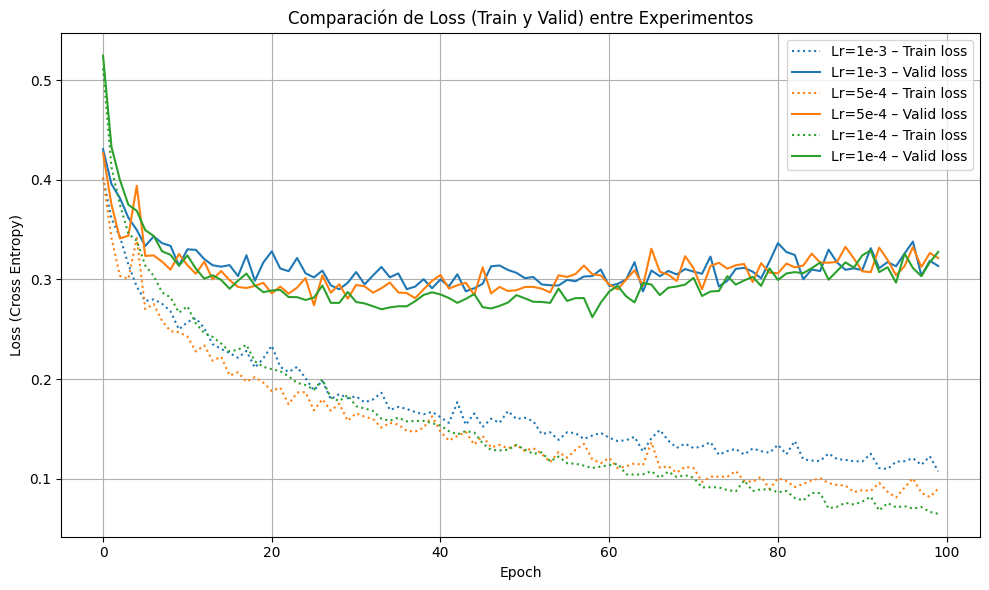

✔ Gráfico guardado en: experimentos_resultados/loss_vs_epoch_comparativo.png


In [27]:
import torch
import matplotlib.pyplot as plt
import os

# ---------------------------------------------------------
#    ARCHIVOS DE MÉTRICAS GUARDADOS DE CADA EXPERIMENTO
# ---------------------------------------------------------
ruta = "experimentos_resultados"

experimentos = {
    "Lr=1e-3": os.path.join(ruta, "exp_1_metrics.pt"),
    "Lr=5e-4": os.path.join(ruta, "exp_2_metrics.pt"),
    "Lr=1e-4": os.path.join(ruta, "exp_3_metrics.pt")
}

# ---------------------------------------------------------
#    CARGA DE MÉTRICAS
# ---------------------------------------------------------
metricas = {}

for nombre, archivo in experimentos.items():
    if not os.path.exists(archivo):
        print(f"ERROR: No se encuentra {archivo}")
        continue

    data = torch.load(archivo)
    metricas[nombre] = {
        "train_loss": data["train_loss"],
        "valid_loss": data["valid_loss"]
    }

print("✔ Métricas cargadas correctamente\n")

# ---------------------------------------------------------
#     GRAFICAR LOSS vs EPOCH PARA LOS 3 EXPERIMENTOS
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# Paleta fija: un color por experimento
colores = ["tab:blue", "tab:orange", "tab:green"]

for (nombre, datos), color in zip(metricas.items(), colores):
    plt.plot(datos["train_loss"], linestyle=":", color=color,
             label=f"{nombre} – Train loss")
    plt.plot(datos["valid_loss"], linestyle="-", color=color,
             label=f"{nombre} – Valid loss")

plt.title("Comparación de Loss (Train y Valid) entre Experimentos")
plt.xlabel("Epoch")
plt.ylabel("Loss (Cross Entropy)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("experimentos_resultados/loss_vs_epoch_comparativo.png", dpi=300)
plt.show()

print("✔ Gráfico guardado en: experimentos_resultados/loss_vs_epoch_comparativo.png")

✔ Métricas cargadas correctamente



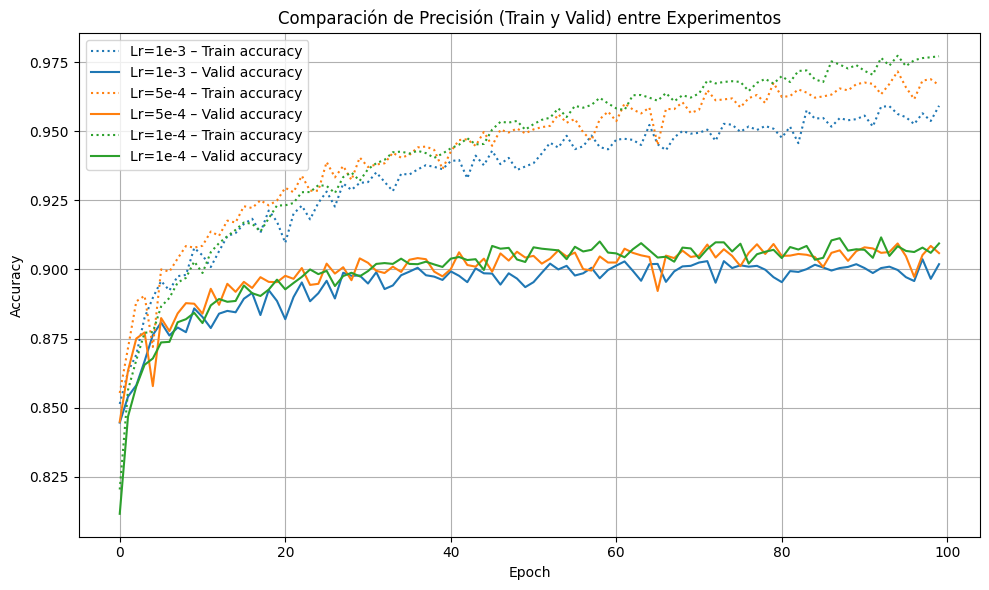

✔ Gráfico guardado en: experimentos_resultados/precision_vs_epoch_comparativo.png


In [29]:
import torch
import matplotlib.pyplot as plt
import os

# ---------------------------------------------------------
#    ARCHIVOS DE MÉTRICAS GUARDADOS DE CADA EXPERIMENTO
# ---------------------------------------------------------
ruta = "experimentos_resultados"

experimentos = {
    "Lr=1e-3": os.path.join(ruta, "exp_1_metrics.pt"),
    "Lr=5e-4": os.path.join(ruta, "exp_2_metrics.pt"),
    "Lr=1e-4": os.path.join(ruta, "exp_3_metrics.pt")
}

# ---------------------------------------------------------
#    CARGA DE MÉTRICAS
# ---------------------------------------------------------
metricas = {}

for nombre, archivo in experimentos.items():
    if not os.path.exists(archivo):
        print(f"ERROR: No se encuentra {archivo}")
        continue

    data = torch.load(archivo)
    metricas[nombre] = {
        "train_prec": data["train_precision"],
        "valid_prec": data["valid_precision"]
    }

print("✔ Métricas cargadas correctamente\n")

# ---------------------------------------------------------
#     GRAFICAR PRECISIÓN vs EPOCH (Train y Valid)
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))

# Paleta fija: un color por experimento
colores = ["tab:blue", "tab:orange", "tab:green"]

for (nombre, datos), color in zip(metricas.items(), colores):
    plt.plot(datos["train_prec"], linestyle=":", color=color,
             label=f"{nombre} – Train accuracy")
    plt.plot(datos["valid_prec"], linestyle="-", color=color,
             label=f"{nombre} – Valid accuracy")

plt.title("Comparación de Precisión (Train y Valid) entre Experimentos")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("experimentos_resultados/precision_vs_epoch_comparativo.png", dpi=300)
plt.show()

print("✔ Gráfico guardado en: experimentos_resultados/precision_vs_epoch_comparativo.png")


✔ Métricas del Experimento 3 cargadas correctamente



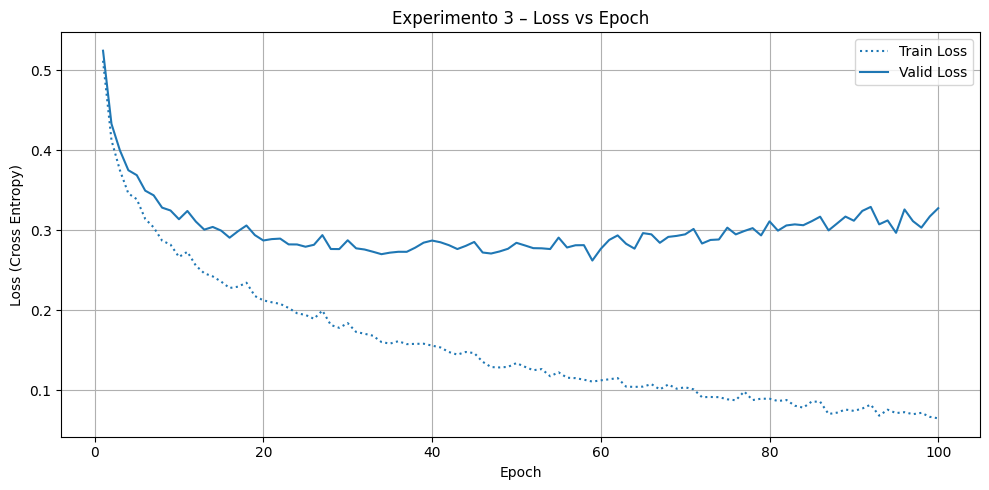

✔ Gráfico de LOSS guardado.


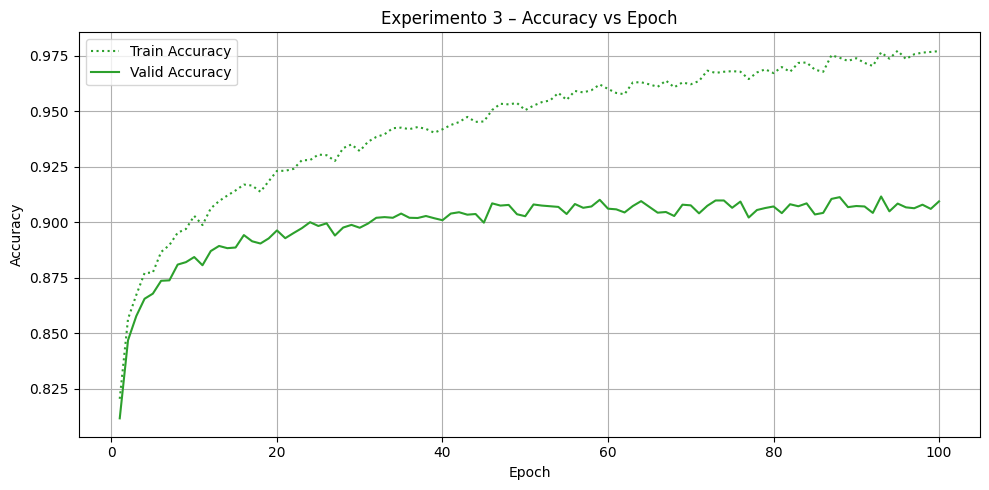

✔ Gráfico de ACCURACY guardado.


In [31]:
import torch
import matplotlib.pyplot as plt
import os

# Ruta del archivo de métricas del Experimento 3
ruta_metricas = "experimentos_resultados/exp_3_metrics.pt"

# Cargar métricas
data = torch.load(ruta_metricas)

train_loss = data["train_loss"]
valid_loss = data["valid_loss"]
train_acc = data["train_precision"]
valid_acc = data["valid_precision"]

num_epochs = len(train_loss)
epochs = list(range(1, num_epochs + 1))

print("✔ Métricas del Experimento 3 cargadas correctamente\n")

# ---------------------------------------------------------
# 1) LOSS vs EPOCH
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))

plt.plot(epochs, train_loss, linestyle=":", color="tab:blue",
         label="Train Loss")
plt.plot(epochs, valid_loss, linestyle="-", color="tab:blue",
         label="Valid Loss")

plt.title("Experimento 3 – Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss (Cross Entropy)")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("experimentos_resultados/exp3_loss_vs_epoch.png", dpi=300)
plt.show()

print("✔ Gráfico de LOSS guardado.")

# ---------------------------------------------------------
# 2) ACCURACY vs EPOCH
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))

plt.plot(epochs, train_acc, linestyle=":", color="tab:green",
         label="Train Accuracy")
plt.plot(epochs, valid_acc, linestyle="-", color="tab:green",
         label="Valid Accuracy")

plt.title("Experimento 3 – Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("experimentos_resultados/exp3_accuracy_vs_epoch.png", dpi=300)
plt.show()

print("✔ Gráfico de ACCURACY guardado.")



✔ Mejor experimento: Exp 3
  - Accuracy valid final = 0.9094
  - Model path: experimentos_resultados/exp_3_model.pt


<Figure size 600x600 with 0 Axes>

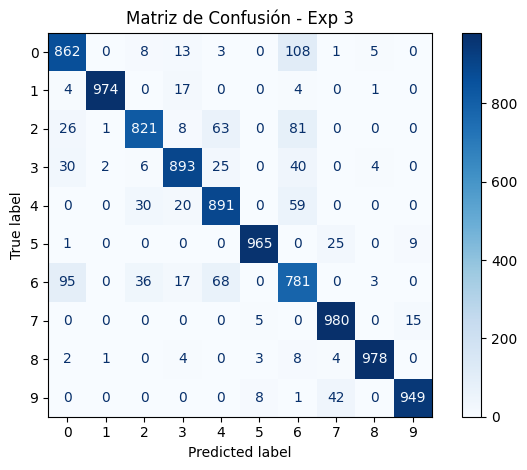


✔ Matriz de confusión guardada en: experimentos_resultados/matriz_confusion_Exp_3.png


In [ ]:
import torch
import json
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------
#   1) Cargar JSON global con los resultados
# ---------------------------------------------------------
json_path = "experimentos_resultados/resultados.json"

with open(json_path, "r") as f:
    resultados = json.load(f)

# ---------------------------------------------------------
#   2) Seleccionar el mejor experimento
#       (criterio: mayor valid_precision final)
# ---------------------------------------------------------
mejor_exp = max(resultados.items(), key=lambda x: x[1]["final_valid_precision"])
nombre_exp, datos_exp = mejor_exp

print(f"\n✔ Mejor experimento: {nombre_exp}")
print(f"  - Accuracy valid final = {datos_exp['final_valid_precision']:.4f}")
print(f"  - Model path: {datos_exp['model_path']}")

# ---------------------------------------------------------
#   3) Cargar el modelo del mejor experimento
# ---------------------------------------------------------
# IMPORTANTE → Se asume que ya tenés definida la clase Clasificadora
clasificador = Clasificadora(
    p=p_dropout_clf,
    n1=n1,
    n2=n2,
    encoder=autoencoder.encoder
).to(device)

clasificador.load_state_dict(torch.load(datos_exp["model_path"], map_location=device))
clasificador.eval()

# ---------------------------------------------------------
#   4) Obtener predicciones sobre VALID para matriz de confusión
# ---------------------------------------------------------
y_true = []
y_pred = []

with torch.no_grad():
    for x, labels in valid_loader:
        x, labels = x.to(device), labels.to(device)
        outputs = clasificador(x)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# ---------------------------------------------------------
#   5) Crear matriz de confusión
# ---------------------------------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Matriz de Confusión - {nombre_exp}")
plt.tight_layout()

output_png = f"experimentos_resultados/matriz_confusion_{nombre_exp.replace(' ', '_').replace('(', '').replace(')', '')}.png"
plt.savefig(output_png, dpi=300)
plt.show()

print(f"\n✔ Matriz de confusión guardada en: {output_png}")



 Generando matriz de confusión para: Exp 1


<Figure size 600x600 with 0 Axes>

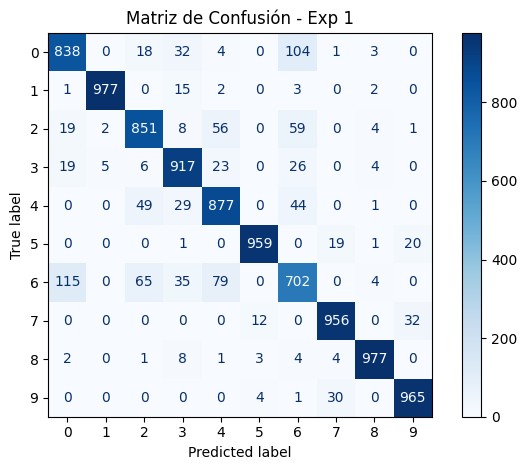

✔ Matriz guardada en experimentos_resultados/confusion_matrix_Exp_1.png

 Generando matriz de confusión para: Exp 2


<Figure size 600x600 with 0 Axes>

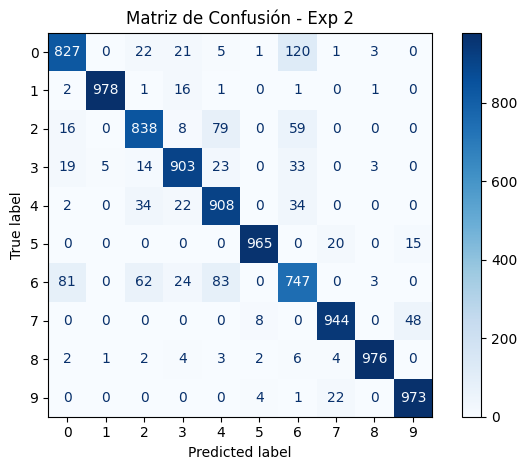

✔ Matriz guardada en experimentos_resultados/confusion_matrix_Exp_2.png

 Generando matriz de confusión para: Exp 3


<Figure size 600x600 with 0 Axes>

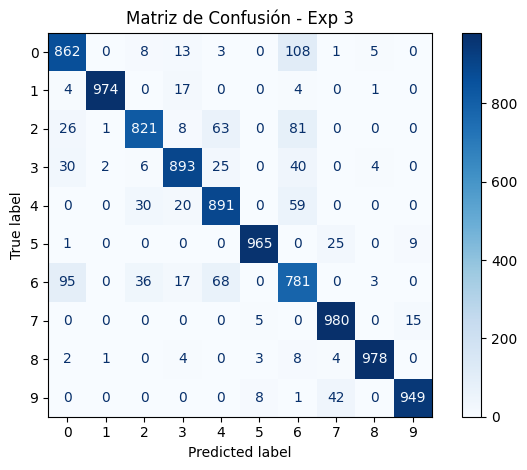

✔ Matriz guardada en experimentos_resultados/confusion_matrix_Exp_3.png

✔ Todas las matrices de confusión fueron generadas correctamente.


In [30]:
import torch
import json
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------------------------------------
#   1) Cargar JSON global con los resultados
# ---------------------------------------------------------
json_path = "experimentos_resultados/resultados.json"

with open(json_path, "r") as f:
    resultados = json.load(f)

# ---------------------------------------------------------
#   2) Iterar sobre los 3 experimentos
# ---------------------------------------------------------
for nombre_exp, datos_exp in resultados.items():

    print(f"\n=====================================")
    print(f" Generando matriz de confusión para: {nombre_exp}")
    print(f"=====================================")

    model_path = datos_exp["model_path"]

    # ---------------------------------------------------------
    #   3) Cargar el modelo del experimento
    # ---------------------------------------------------------
    clasificador = Clasificadora(
        p=p_dropout_clf,
        n1=n1,
        n2=n2,
        encoder=autoencoder.encoder
    ).to(device)

    clasificador.load_state_dict(torch.load(model_path, map_location=device))
    clasificador.eval()

    # ---------------------------------------------------------
    #   4) Evaluar sobre VALID
    # ---------------------------------------------------------
    y_true = []
    y_pred = []

    with torch.no_grad():
        for x, labels in valid_loader:
            x, labels = x.to(device), labels.to(device)
            outputs = clasificador(x)
            preds = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # ---------------------------------------------------------
    #   5) Matriz de confusión
    # ---------------------------------------------------------
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Matriz de Confusión - {nombre_exp}")
    plt.tight_layout()

    # Nombre seguro para archivo
    nombre_archivo = nombre_exp.replace(" ", "_").replace("(", "").replace(")", "").replace("=", "")
    output_png = f"experimentos_resultados/confusion_matrix_{nombre_archivo}.png"

    plt.savefig(output_png, dpi=300)
    plt.show()

    print(f"✔ Matriz guardada en {output_png}")

print("\n✔ Todas las matrices de confusión fueron generadas correctamente.")
